# Dữ liệu

## Gọi bộ dữ liệu

In [42]:
import pandas as pd

In [ ]:
# Gọi bộ dữ liệu đã lưu, trong folder /content, đã chia Train/Valid : Test theo tỉ lệ 8:2
path = "data/cleaned_final"
train_valid_processed_comments = pd.read_csv(f"{path}/train_valid_processed_comments.csv")
test_processed_comments = pd.read_csv(f"{path}/test_processed_comments.csv")

In [44]:
train_valid_processed_comments.shape, test_processed_comments.shape

((8624, 4), (2156, 4))

In [45]:
test_processed_comments.head(3)

,Sentence,Emotion,Tokenized_Sentence,tokens_length
0,bố khỉ chó chứ kphai người chán,Disgust,"['bố', 'khỉ', 'chó', 'kphai', 'người', 'chán']",46
1,per anh tải cái này về cho per học nè . thú vị...,Enjoyment,"['anh', 'tải', 'cái', 'về', 'học', 'thú vị', '...",51
2,con nào cũng là con nhé . con trai tao tập từ ...,Enjoyment,"['con', 'nào', 'cũng', 'con', 'con', 'trai', '...",109


## Chuyển đổi cột *Tokenized_Sentence* về danh sách từ

In [46]:
texts = test_processed_comments['Tokenized_Sentence']

# Kiểm tra kiểu phần tử
print("Kiểu phần tử:", type(texts.iloc[0]))
print("5 phần tử đầu tiên:", texts.iloc[:5].tolist())

Kiểu phần tử: <class 'str'>
5 phần tử đầu tiên: ["['bố', 'khỉ', 'chó', 'kphai', 'người', 'chán']", "['anh', 'tải', 'cái', 'về', 'học', 'thú vị', 'ghê']", "['con', 'nào', 'cũng', 'con', 'con', 'trai', 'tao', 'tập', 'từ', 'nhỏ', 'biết', 'tự', 'lo', 'phụ mẹ', 'cười']", "['gì', 'cũng', 'được', 'yêu', '1', 'người', 'vô tâm', 'đéo', 'mỉm_cười']", "['vãi', 'cả', 'lồn', 'haha', 'càng', 'lên', 'mạng', 'tôi', 'càng', 'thấy', 'số', 'mình', 'tốt', 'cười']"]


**Do dữ liệu đã được tiền xử lý và lưu dưới dạng chuỗi, ta cần chuyển đổi chúng trở lại thành danh sách từ**

In [47]:
import ast

# Sử dụng hàm literal_eval để chuyển chuỗi thành danh sách
train_valid_processed_comments['Tokenized_Sentence'] = train_valid_processed_comments['Tokenized_Sentence'].apply(ast.literal_eval)
test_processed_comments['Tokenized_Sentence'] = test_processed_comments['Tokenized_Sentence'].apply(ast.literal_eval)

In [48]:
texts = test_processed_comments['Tokenized_Sentence']

# Kiểm tra kiểu phần tử sau khi chuyển đổi
print("Kiểu phần tử:", type(texts.iloc[0]))
print("5 phần tử đầu tiên:", texts.iloc[:5].tolist())

Kiểu phần tử: <class 'list'>
5 phần tử đầu tiên: [['bố', 'khỉ', 'chó', 'kphai', 'người', 'chán'], ['anh', 'tải', 'cái', 'về', 'học', 'thú vị', 'ghê'], ['con', 'nào', 'cũng', 'con', 'con', 'trai', 'tao', 'tập', 'từ', 'nhỏ', 'biết', 'tự', 'lo', 'phụ mẹ', 'cười'], ['gì', 'cũng', 'được', 'yêu', '1', 'người', 'vô tâm', 'đéo', 'mỉm_cười'], ['vãi', 'cả', 'lồn', 'haha', 'càng', 'lên', 'mạng', 'tôi', 'càng', 'thấy', 'số', 'mình', 'tốt', 'cười']]


# Các hàm xử lý

## Tách các tập Train - Validation - Test và label

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
def split_train_valid_test(df_train_valid, df_test, train_size, valid_size, random_state=11):
    X_train, X_valid, y_train, y_valid = train_test_split(
        df_train_valid.drop('Emotion', axis=1),
        df_train_valid['Emotion'],
        test_size=valid_size/(train_size + valid_size),
        random_state=random_state,
        stratify=df_train_valid['Emotion']
    )

    X_test = df_test.drop('Emotion', axis=1)
    y_test = df_test['Emotion']

    return X_train, X_valid, X_test, y_train, y_valid, y_test

## TF-IDF
**TF-IDF = Term Frequency * Inverse Document Frequency**
- Từ xuất hiện nhiều trong câu nhưng ít trong toàn bộ corpus => trọng số cao
- Từ phổ biến (stop words) => trọng số thấp

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_embedding(tokens, max_features=8000, min_df=2, max_df=0.95):
    # Chuyển đổi danh sách token thành TF-IDF representation
    # max_features : Số lượng từ vựng tối đa mà  (mặc định: 8000)
    # tokens: Danh sách các token

    # Chuyển danh sách token thành chuỗi văn bản
    texts = [' '.join(token_list) for token_list in tokens]

    # Khởi tạo TfidfVectorizer
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1, 2), # Sử dụng unigram và bigram
        min_df=min_df,           # Bỏ qua từ xuất hiện < min_df lần
        max_df=max_df         # Bỏ qua từ xuất hiện > max_df documents
    )

    # fit_transform
    # ma trận TF-IDF (n_samples x n_features)
    tfidf_matrix = vectorizer.fit_transform(texts)

    print("TF-IDF hoàn thành!")
    print(f"Shape: {tfidf_matrix.shape} (số câu x số từ vựng)")
    print("Số từ vựng:", len(vectorizer.get_feature_names_out()))
    print("TF-IDF - Non-zero values:", tfidf_matrix.nnz)

    return tfidf_matrix, vectorizer

In [52]:
def tfidf_transform(tokens, tfidf_vectorizer):
    texts = [' '.join(token_list) for token_list in tokens]
    return tfidf_vectorizer.transform(texts)

## Chuyển sang mảng numpy

In [53]:
def convert_to_array(tfidf_matrix):
    return tfidf_matrix.toarray()

In [54]:
def convert_full_to_array(train_tfidf_matrix, valid_tfidf_matrix, test_tfidf_matrix):
    return convert_to_array(train_tfidf_matrix), convert_to_array(valid_tfidf_matrix), convert_to_array(test_tfidf_matrix)

## Giảm chiều

### PCA
Giữ lại 90% thông tin sau khi PCA

In [55]:
from sklearn.decomposition import PCA

In [56]:
def pca(X_train_arr, X_test_arr, X_valid_arr, n_components=0.9):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_arr)
    X_test_pca = pca.transform(X_test_arr)
    X_valid_pca = pca.transform(X_valid_arr)

    return pca, X_train_pca, X_test_pca, X_valid_pca

### LDA

- Tìm ma trận W chiếu DL vào không gian LDA
- Sau khi học được W, tính các hàm phân biệt tuyến tính (linear discriminats) để dự đoán lớp
- Thay vì mỗi TPC giữ một phần thông tin như PCA, thì LDA sẽ giữ một phần thông tin giúp phân biệt giữa các lớp
- Vì thế, LDA có thể giảm còn số chiều max là (n-1) chiều (n là số nhãn)

In [57]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

#### LDA còn 6 chiều

In [58]:
def lda(X_train_arr, y_train, X_test_arr, X_valid_arr, n_components):
    lda = LDA(n_components=n_components)
    X_train_lda =lda.fit_transform(X_train_arr, y_train)
    X_test_lda = lda.transform(X_test_arr)
    X_valid_lda = lda.transform(X_valid_arr)

    return lda, X_train_lda, X_test_lda, X_valid_lda

- LDA tìm ra 6 hướng giúp phân biệt tâm của 7 label
- Các vector riêng của S_w^-1 * S_B mô tả toàn bộ thông tin phân biệt giữa các lớp, tức là TOÀN BỘ KHẢ NĂNG PHÂN BIỆT đã ở trong 6 chiều này

### Hàm lựa chọn giảm chiều theo cách nào

In [59]:
def use_discriminant(X_train_arr, y_train, X_test_arr, X_valid_arr, discriminant="none", n_components_pca=0.9, n_components_lda=6):
    if discriminant == "pca":
        return pca(X_train_arr, X_test_arr, X_valid_arr, n_components_pca)

    elif discriminant == "lda":
        return lda(X_train_arr, y_train, X_test_arr, X_valid_arr, n_components_lda)

    return None, X_train_arr, X_test_arr, X_valid_arr

## Model

In [60]:
import time

### HOI QUY SOFTMAX - *MULTINOMIAL LOGISTIC REGRESSION*

In [61]:
from sklearn.linear_model import LogisticRegression

In [62]:
def log_reg(X_train, y_train, random_state=11, max_iter=1000):
    log_reg = LogisticRegression(
        multi_class='multinomial',
        class_weight='balanced',
        random_state=random_state,
        max_iter=max_iter)

    log_reg.fit(X_train, y_train)

    return log_reg

### K-NN

In [63]:
from sklearn.neighbors import KNeighborsClassifier

In [64]:
def knn(X_train, y_train, metric = 'cosine'):
    knn = KNeighborsClassifier(
    n_neighbors=83,
    metric=metric,
    n_jobs=-1)  # Dùng tất cả CPU cores để tăng tốc độ chạy

    knn.fit(X_train, y_train)

    return knn

### Hàm lựa chọn mô hình và Hàm dự đoán

In [65]:
def use_model(model_type, X_train_processed, y_train, metric = 'cosine', max_iter=1000):
    if model_type == "logistic_regression":
        model = log_reg(X_train_processed, y_train, max_iter)
    elif model_type == "knn":
        model = knn(X_train_processed, y_train, metric)

    return model

In [66]:
def predict(model, X_train, X_valid, X_test):
    # model là log_reg hoặc knn

    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)
    y_pred_test = model.predict(X_test)

    return y_pred_train, y_pred_valid, y_pred_test

## Đánh giá độ chính xác và Trực quan

### Đánh giá độ chính xác

In [67]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [68]:
def get_metrics(y_true, y_pred):
    return accuracy_score(y_true, y_pred), precision_score(y_true, y_pred, average='weighted'), recall_score(y_true, y_pred, average='weighted'), f1_score(y_true, y_pred, average='weighted')

In [69]:
def get_full_data_metrics(y_train, y_valid, y_test, y_pred_train, y_pred_valid, y_pred_test):
    accuracy_train, precision_train, recall_train, f1_train = get_metrics(y_train, y_pred_train)
    accuracy_valid, precision_valid, recall_valid, f1_valid = get_metrics(y_valid, y_pred_valid)
    accuracy_test, precision_test, recall_test, f1_test = get_metrics(y_test, y_pred_test)

    return [accuracy_train, precision_train, recall_train, f1_train], [accuracy_valid, precision_valid, recall_valid, f1_valid], [accuracy_test, precision_test, recall_test, f1_test]

In [70]:
def print_metrics(accuracy, precision, recall, f1):
    print("Accuracy:", accuracy)
    print("Recall:", recall)
    print("Precision:", precision)
    print("F1-score:", f1)

### Trực quan

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
# vẽ ma trận nhầm lẫn
def plot_normalized_confusion_matrix(y_true, y_pred, title='Normalized Confusion Matrix'):
    cm_normalized = confusion_matrix(y_true, y_pred, normalize='true')
    classes = np.unique(y_true)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [73]:
# hàm vẽ cả 3 ma trận nhầm lẫn cho cả 3 tập train - valid - test
def plot_full_normalized_confusion_matrix(y_train, y_valid, y_test, y_pred_train, y_pred_valid, y_pred_test,
                                          title='Normalized Confusion Matrix', discriminant="none", model_type="logistic_regression"):
    plot_normalized_confusion_matrix(y_train, y_pred_train, title=title + " Train " + discriminant + " " + model_type)
    plot_normalized_confusion_matrix(y_valid, y_pred_valid, title=title + " Valid " + discriminant + " " + model_type)
    plot_normalized_confusion_matrix(y_test, y_pred_test, title=title + " Test " + discriminant + " " + model_type)

# Pipeline

## Huấn luyện mô hình

In [ ]:
def pipeline_modeling(df_train_valid, df_test, train_size, valid_size, random_state=11,
                      vectorizer="tf_idf", min_df=2, max_df=0.95, max_features=8000,
                      discriminant="none", n_components_pca=0.9, n_components_lda=6,
                      model_type="logistic_regression", max_iter=1000, metric='cosine'):

    # Tách các tập Train - Validation - Test và label
    X_train, X_valid, X_test, y_train, y_valid, y_test = split_train_valid_test(df_train_valid, df_test, train_size, valid_size, random_state)

    # Vectorizer
    if vectorizer == "tf_idf":
        # fit_transform
        train_tfidf_matrix, tfidf_vectorizer = tfidf_embedding(X_train['Tokenized_Sentence'], max_features=max_features, min_df=min_df, max_df=max_df)

        # transform
        valid_tfidf_matrix = tfidf_transform(X_valid['Tokenized_Sentence'], tfidf_vectorizer)
        test_tfidf_matrix = tfidf_transform(X_test['Tokenized_Sentence'], tfidf_vectorizer)

        # Chuyển sang mảng numpy
        X_train_processed, X_valid_processed, X_test_processed = convert_full_to_array(train_tfidf_matrix, valid_tfidf_matrix, test_tfidf_matrix)

    # Giảm chiều
    discriminant_model, X_train_processed, X_test_processed, X_valid_processed = use_discriminant(X_train_processed, y_train, X_test_processed, X_valid_processed,
                                                                                                  discriminant, n_components_pca, n_components_lda)

    # Huấn luyện mô hình
    model = use_model(model_type, X_train_processed, y_train, metric, max_iter)

    # Dự đoán
    y_pred_train, y_pred_valid, y_pred_test = predict(model, X_train_processed, X_valid_processed, X_test_processed)


    return model, [X_train_processed, y_train], [X_valid_processed, y_valid], [X_test_processed, y_test], [y_pred_train, y_pred_valid, y_pred_test]

## Đánh giá độ chính xác và trực quan

In [75]:
# đánh giá độ chính xác và trực quan
def pipeline_evaluation(y_train, y_valid, y_test,
                        y_pred_train, y_pred_valid, y_pred_test,
                        train_size, valid_size, discriminant, model_type,
                        show_plot=True):

    metrics_train, metrics_valid, metrics_test = get_full_data_metrics(y_train, y_valid, y_test, y_pred_train, y_pred_valid, y_pred_test)

    # train
    print(f"--- train --- {train_size}:{valid_size} --- {model_type} --- {discriminant} ---")
    print_metrics(metrics_train[0], metrics_train[1], metrics_train[2], metrics_train[3])

    print()

    # valid
    print(f"--- valid --- {train_size}:{valid_size} --- {model_type} --- {discriminant} ---")
    print_metrics(metrics_valid[0], metrics_valid[1], metrics_valid[2], metrics_valid[3])

    print()

    # test
    print(f"--- test --- {train_size}:{valid_size} --- {model_type} --- {discriminant} ---")
    print_metrics(metrics_test[0], metrics_test[1], metrics_test[2], metrics_test[3])

    # trực quan
    if show_plot: plot_full_normalized_confusion_matrix(y_train, y_valid, y_test, y_pred_train, y_pred_valid, y_pred_test,
                                                        discriminant=discriminant, model_type=model_type)

# **Chạy pipeline**

# Test:Validation = 8:2

## Logistic Regression

### Bộ dữ liệu không giảm chiều

TF-IDF hoàn thành!
Shape: (6899, 8000) (số câu x số từ vựng)
Số từ vựng: 8000
TF-IDF - Non-zero values: 77132


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


--- train --- 8:2 --- logistic_regression --- none ---
Accuracy: 0.7873604870271054
Recall: 0.7873604870271054
Precision: 0.8034486092381581
F1-score: 0.7878104369071537

--- valid --- 8:2 --- logistic_regression --- none ---
Accuracy: 0.5310144927536232
Recall: 0.5310144927536232
Precision: 0.5493866548089584
F1-score: 0.5361889778206334

--- test --- 8:2 --- logistic_regression --- none ---
Accuracy: 0.5412801484230055
Recall: 0.5412801484230055
Precision: 0.5631369279302777
F1-score: 0.54761940562689


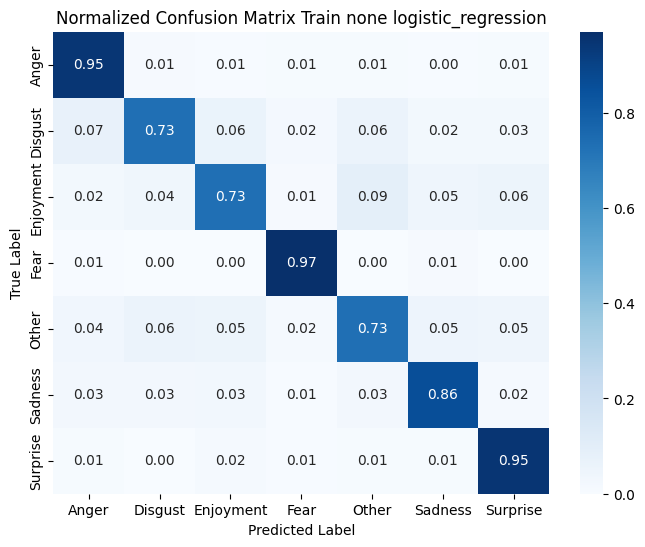

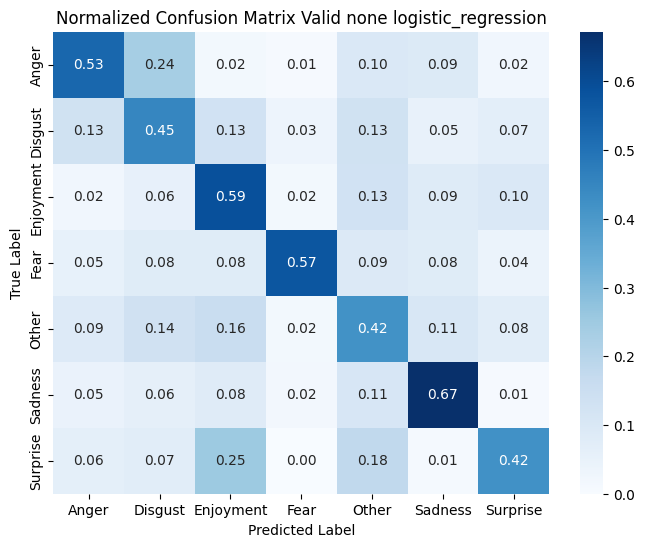

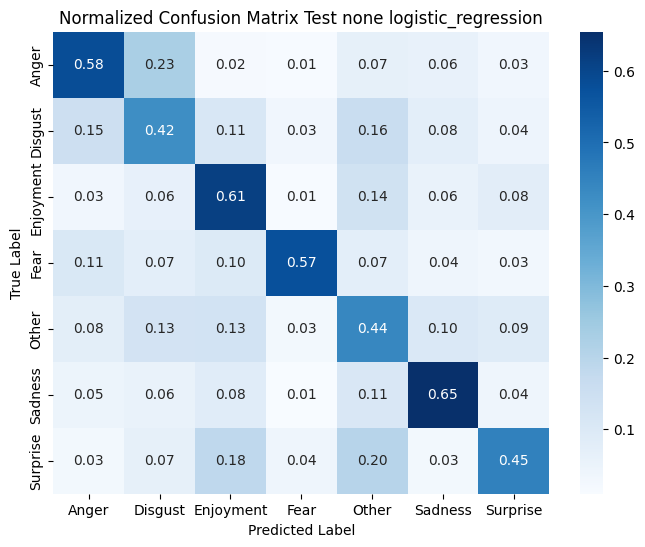

In [76]:
model_1, train_1, valid_1, test_1, pred_1 = pipeline_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=8,
    valid_size=2,
    discriminant="none",
    model_type="logistic_regression",
    max_iter=1000
)

y_train_1, y_valid_1, y_test_1 = train_1[1], valid_1[1], test_1[1]
y_pred_train_1, y_pred_valid_1, y_pred_test_1 = pred_1

pipeline_evaluation(
    y_train_1, y_valid_1, y_test_1,
    y_pred_train_1, y_pred_valid_1, y_pred_test_1,
    train_size=8, valid_size=2,
    discriminant="none",
    model_type="logistic_regression",
    show_plot=True
)

### Bộ dữ liệu PCA

TF-IDF hoàn thành!
Shape: (6899, 8000) (số câu x số từ vựng)
Số từ vựng: 8000
TF-IDF - Non-zero values: 77132


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


--- train --- 8:2 --- logistic_regression --- pca ---
Accuracy: 0.7469198434555733
Recall: 0.7469198434555733
Precision: 0.7679479708630923
F1-score: 0.7478201250508658

--- valid --- 8:2 --- logistic_regression --- pca ---
Accuracy: 0.5321739130434783
Recall: 0.5321739130434783
Precision: 0.5525555127851094
F1-score: 0.5376925212764259

--- test --- 8:2 --- logistic_regression --- pca ---
Accuracy: 0.5431354359925789
Recall: 0.5431354359925789
Precision: 0.567857584828495
F1-score: 0.5499595933352112


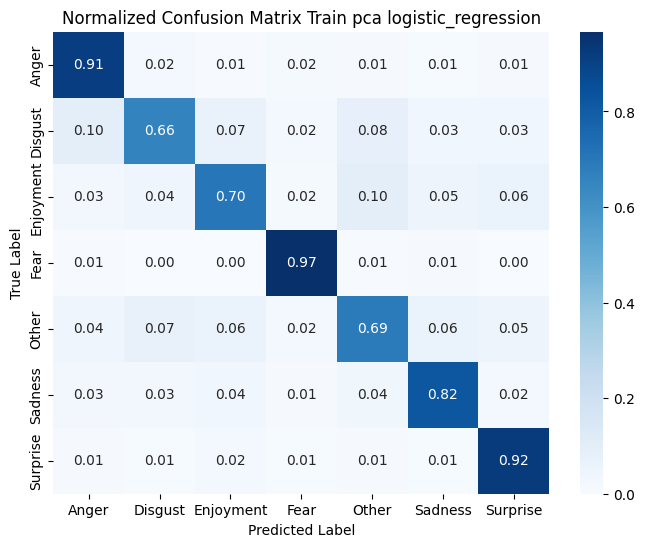

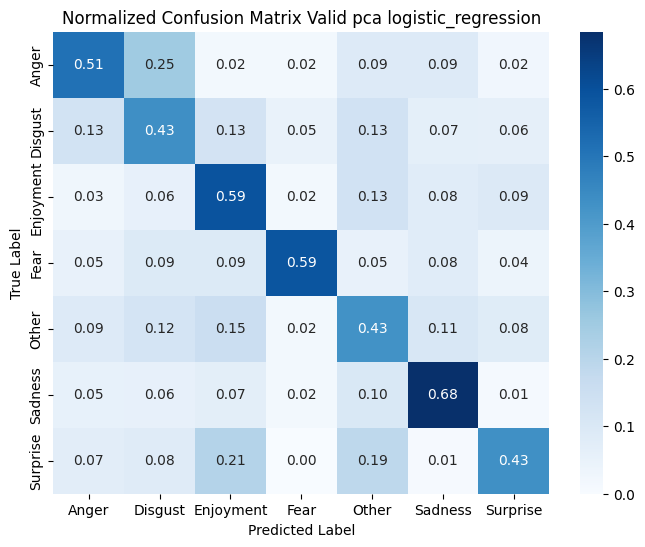

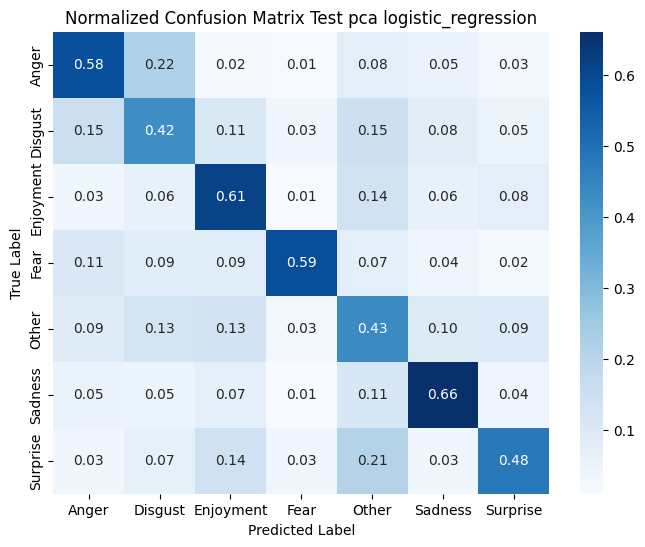

In [77]:
model_pca_1, train_pca_1, valid_pca_1, test_pca_1, pred_pca_1 = pipeline_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=8,
    valid_size=2,
    discriminant="pca", n_components_pca=0.9,
    model_type="logistic_regression",
    max_iter=1000
)

y_train_pca_1, y_valid_pca_1, y_test_pca_1 = train_pca_1[1], valid_pca_1[1], test_pca_1[1]
y_pred_train_pca_1, y_pred_valid_pca_1, y_pred_test_pca_1 = pred_pca_1

pipeline_evaluation(
    y_train_pca_1, y_valid_pca_1, y_test_pca_1,
    y_pred_train_pca_1, y_pred_valid_pca_1, y_pred_test_pca_1,
    train_size=8, valid_size=2,
    discriminant="pca",
    model_type="logistic_regression",
    show_plot=True
)

### Bộ dữ liệu lda

TF-IDF hoàn thành!
Shape: (6899, 8000) (số câu x số từ vựng)
Số từ vựng: 8000
TF-IDF - Non-zero values: 77132


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


--- train --- 8:2 --- logistic_regression --- lda ---
Accuracy: 0.9944919553558487
Recall: 0.9944919553558487
Precision: 0.9946299927907339
F1-score: 0.9945254697011214

--- valid --- 8:2 --- logistic_regression --- lda ---
Accuracy: 0.25507246376811593
Recall: 0.25507246376811593
Precision: 0.3074666831514581
F1-score: 0.26930496524825664

--- test --- 8:2 --- logistic_regression --- lda ---
Accuracy: 0.2634508348794063
Recall: 0.2634508348794063
Precision: 0.29897599416499865
F1-score: 0.2717213407697231


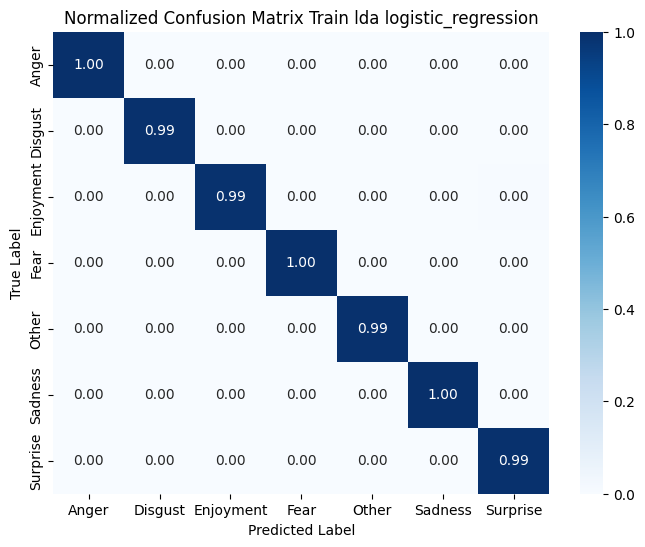

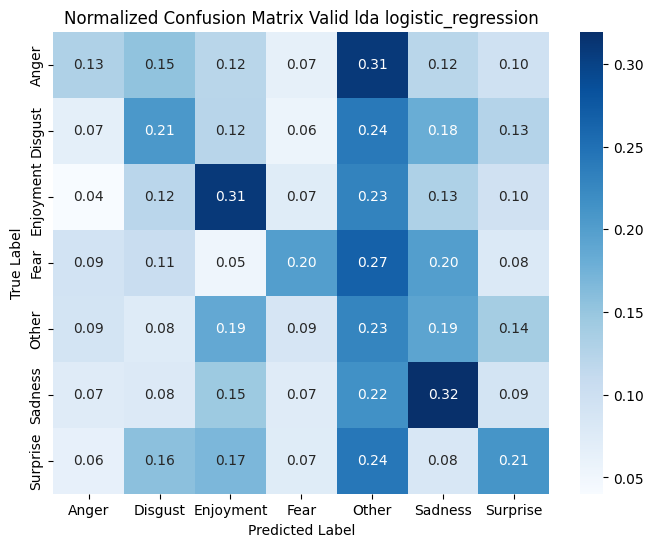

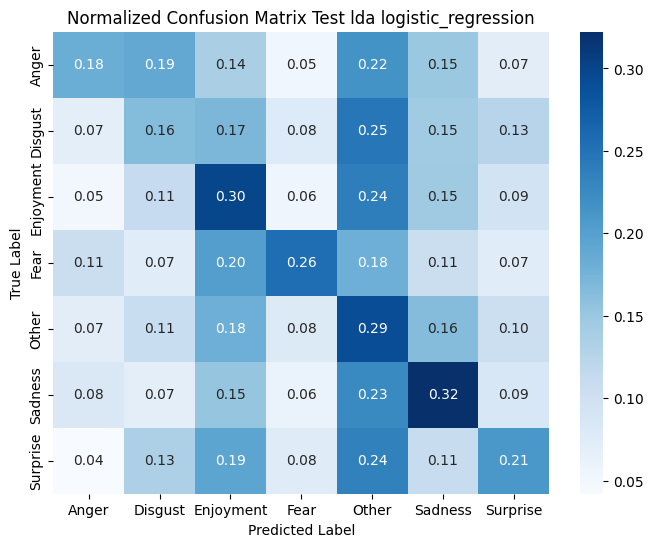

In [78]:
model_lda_1, train_lda_1, valid_lda_1, test_lda_1, pred_lda_1 = pipeline_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=8,
    valid_size=2,
    discriminant="lda", n_components_lda=6,
    model_type="logistic_regression",
    max_iter=1000
)

y_train_lda_1, y_valid_lda_1, y_test_lda_1 = train_lda_1[1], valid_lda_1[1], test_lda_1[1]
y_pred_train_lda_1, y_pred_valid_lda_1, y_pred_test_lda_1 = pred_lda_1

pipeline_evaluation(
    y_train_lda_1, y_valid_lda_1, y_test_lda_1,
    y_pred_train_lda_1, y_pred_valid_lda_1, y_pred_test_lda_1,
    train_size=8, valid_size=2,
    discriminant="lda",
    model_type="logistic_regression",
    show_plot=True
)

## K-NN

### Bộ dữ liệu không giảm chiều

TF-IDF hoàn thành!
Shape: (6899, 8000) (số câu x số từ vựng)
Số từ vựng: 8000
TF-IDF - Non-zero values: 77132
--- train --- 8:2 --- knn --- none ---
Accuracy: 0.7873604870271054
Recall: 0.7873604870271054
Precision: 0.8034486092381581
F1-score: 0.7878104369071537

--- valid --- 8:2 --- knn --- none ---
Accuracy: 0.5310144927536232
Recall: 0.5310144927536232
Precision: 0.5493866548089584
F1-score: 0.5361889778206334

--- test --- 8:2 --- knn --- none ---
Accuracy: 0.5412801484230055
Recall: 0.5412801484230055
Precision: 0.5631369279302777
F1-score: 0.54761940562689


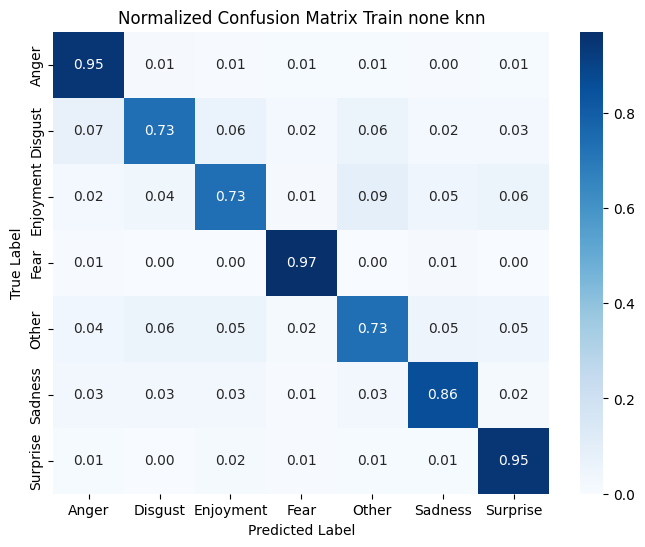

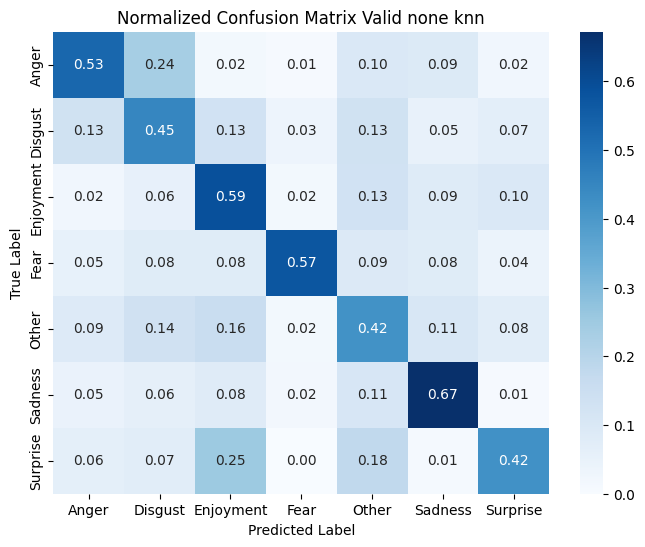

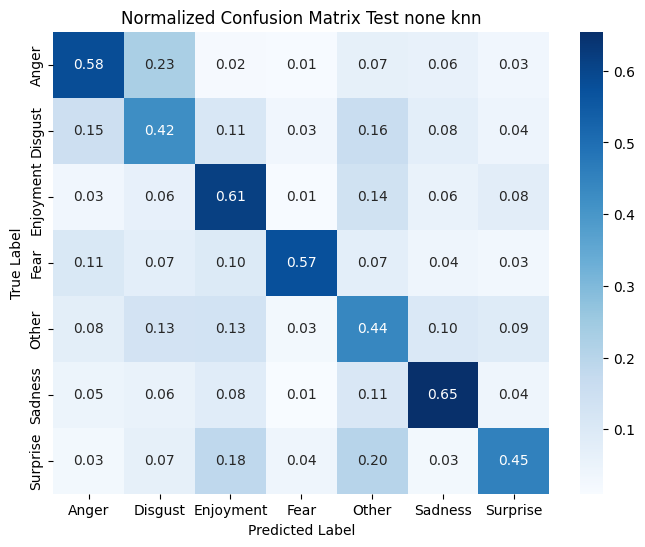

In [79]:
model_2, train_2, valid_2, test_2, pred_2 = pipeline_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=8,
    valid_size=2,
    discriminant="none",
    model_type="knn"
)

y_train_2, y_valid_2, y_test_2 = train_2[1], valid_2[1], test_2[1]
y_pred_train_2, y_pred_valid_2, y_pred_test_2 = pred_2

pipeline_evaluation(
    y_train_1, y_valid_1, y_test_1,
    y_pred_train_1, y_pred_valid_1, y_pred_test_1,
    train_size=8, valid_size=2,
    discriminant="none",
    model_type="knn",
    show_plot=True
)

### Bộ dữ liệu PCA

TF-IDF hoàn thành!
Shape: (6899, 8000) (số câu x số từ vựng)
Số từ vựng: 8000
TF-IDF - Non-zero values: 77132
--- train --- 8:2 --- knn --- pca ---
Accuracy: 0.4807943180171039
Recall: 0.4807943180171039
Precision: 0.535238538318547
F1-score: 0.42562461768239046

--- valid --- 8:2 --- knn --- pca ---
Accuracy: 0.4544927536231884
Recall: 0.4544927536231884
Precision: 0.4770199363025004
F1-score: 0.39314063881666245

--- test --- 8:2 --- knn --- pca ---
Accuracy: 0.4642857142857143
Recall: 0.4642857142857143
Precision: 0.5191104465241986
F1-score: 0.4076461588714787


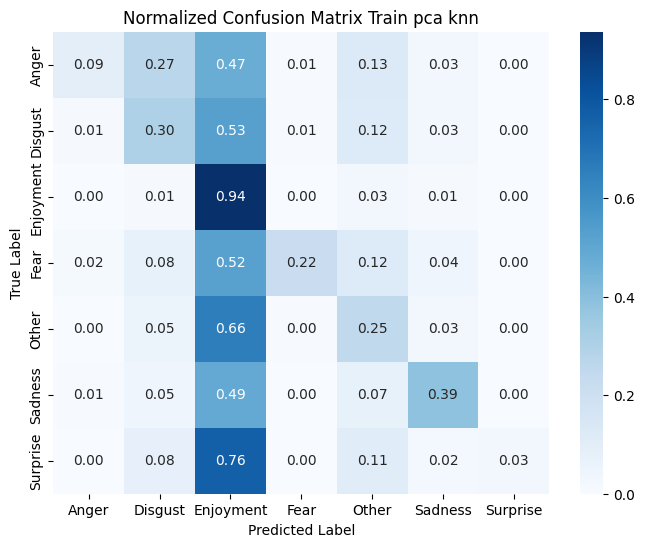

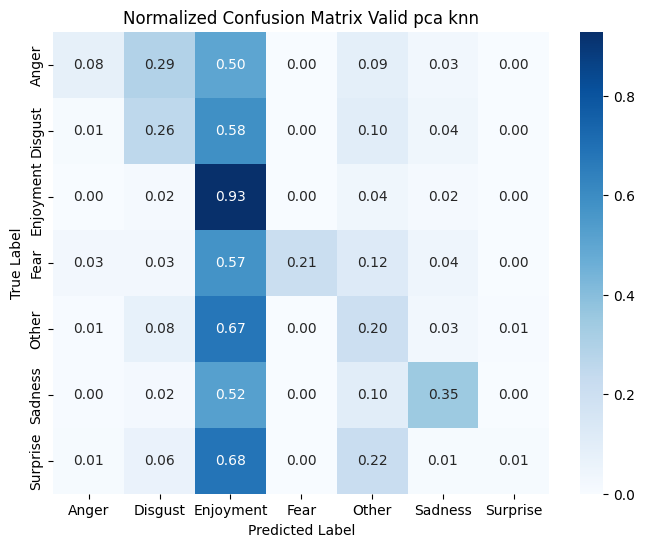

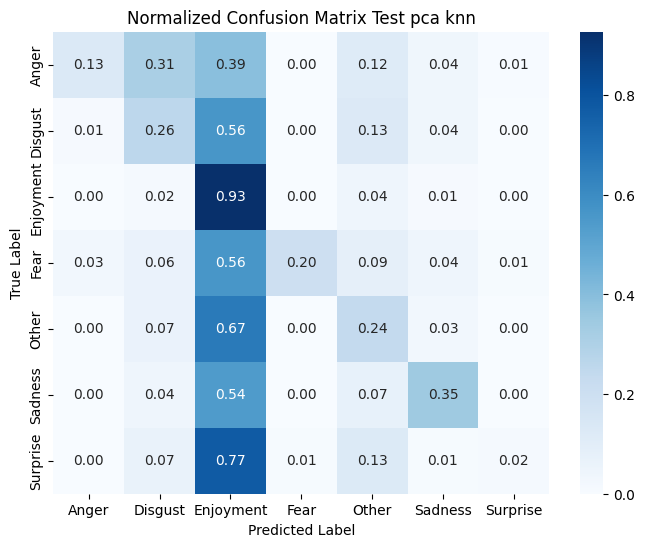

In [80]:
model_pca_2, train_pca_2, valid_pca_2, test_pca_2, pred_pca_2 = pipeline_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=8,
    valid_size=2,
    discriminant="pca", n_components_pca=0.9,
    model_type="knn",
    max_iter=1000
)

y_train_pca_2, y_valid_pca_2, y_test_pca_2 = train_pca_2[1], valid_pca_2[1], test_pca_2[1]
y_pred_train_pca_2, y_pred_valid_pca_2, y_pred_test_pca_2 = pred_pca_2

pipeline_evaluation(
    y_train_pca_2, y_valid_pca_2, y_test_pca_2,
    y_pred_train_pca_2, y_pred_valid_pca_2, y_pred_test_pca_2,
    train_size=8, valid_size=2,
    discriminant="pca",
    model_type="knn",
    show_plot=True
)

### Bộ dữ liệu lda

TF-IDF hoàn thành!
Shape: (6899, 8000) (số câu x số từ vựng)
Số từ vựng: 8000
TF-IDF - Non-zero values: 77132
--- train --- 8:2 --- knn --- lda ---
Accuracy: 0.9934773155529787
Recall: 0.9934773155529787
Precision: 0.9935734645960829
F1-score: 0.993499266104562

--- valid --- 8:2 --- knn --- lda ---
Accuracy: 0.25043478260869567
Recall: 0.25043478260869567
Precision: 0.3260771084087867
F1-score: 0.2684905499366744

--- test --- 8:2 --- knn --- lda ---
Accuracy: 0.25
Recall: 0.25
Precision: 0.313667768951949
F1-score: 0.26122865513323684


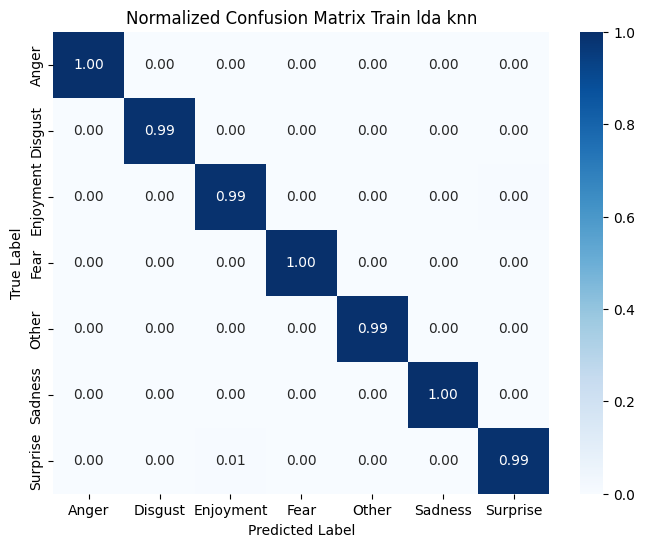

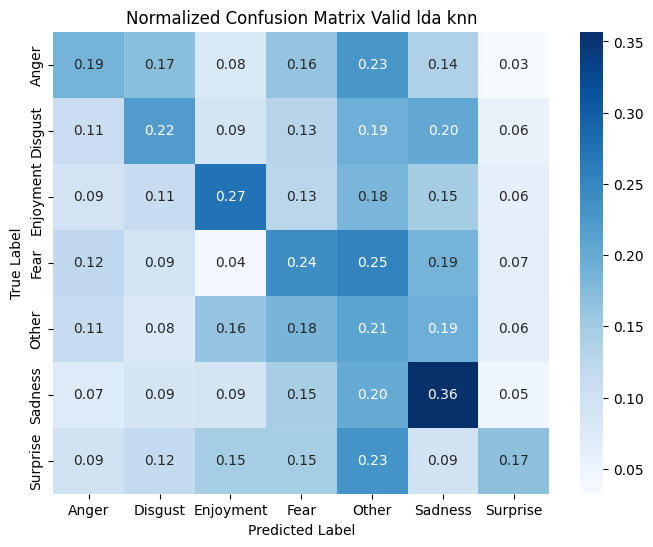

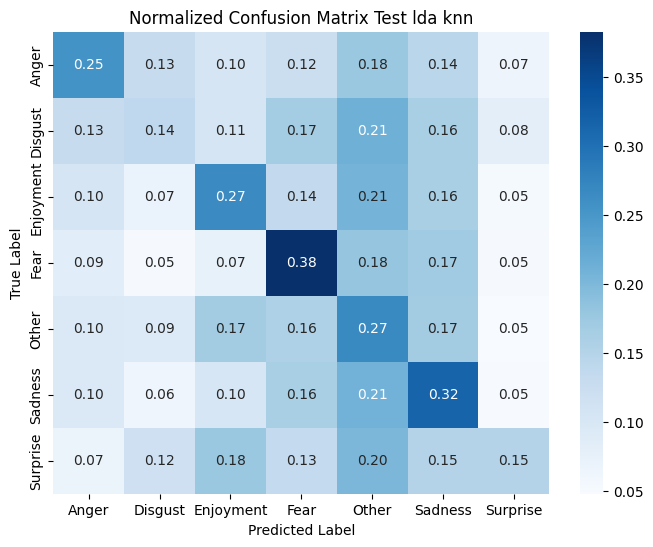

In [81]:
model_lda_2, train_lda_2, valid_lda_2, test_lda_2, pred_lda_2 = pipeline_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=8,
    valid_size=2,
    discriminant="lda", n_components_lda=6,
    model_type="knn",
    max_iter=1000
)

y_train_lda_2, y_valid_lda_2, y_test_lda_2 = train_lda_2[1], valid_lda_2[1], test_lda_2[1]
y_pred_train_lda_2, y_pred_valid_lda_2, y_pred_test_lda_2 = pred_lda_2

pipeline_evaluation(
    y_train_lda_2, y_valid_lda_2, y_test_lda_2,
    y_pred_train_lda_2, y_pred_valid_lda_2, y_pred_test_lda_2,
    train_size=8, valid_size=2,
    discriminant="lda",
    model_type="knn",
    show_plot=True
)

# Test:Validation = 7:3

## Logistic Regression

### Bộ dữ liệu không giảm chiều

TF-IDF hoàn thành!
Shape: (6036, 7991) (số câu x số từ vựng)
Số từ vựng: 7991
TF-IDF - Non-zero values: 68471


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


--- train --- 7:3 --- logistic_regression --- none ---
Accuracy: 0.807819748177601
Recall: 0.807819748177601
Precision: 0.8228381991627267
F1-score: 0.8084060376830123

--- valid --- 7:3 --- logistic_regression --- none ---
Accuracy: 0.526661514683153
Recall: 0.526661514683153
Precision: 0.5447471429802409
F1-score: 0.5322664174858797

--- test --- 7:3 --- logistic_regression --- none ---
Accuracy: 0.5454545454545454
Recall: 0.5454545454545454
Precision: 0.5638303329781851
F1-score: 0.5509995831305966


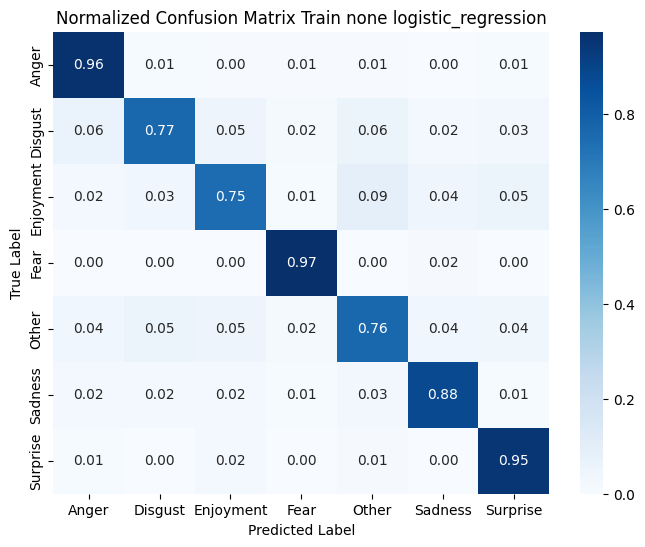

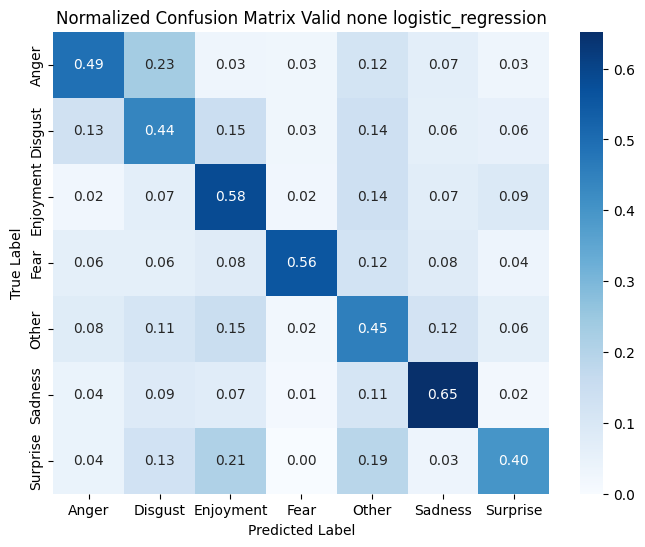

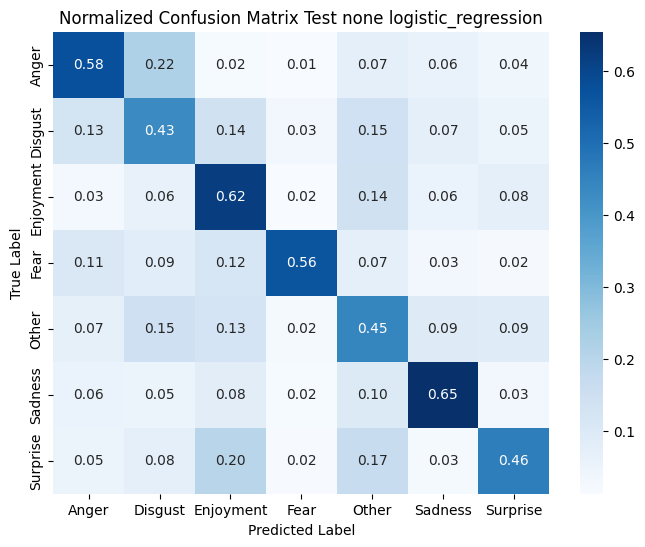

In [82]:
model_3, train_3, valid_3, test_3, pred_3 = pipeline_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=7,
    valid_size=3,
    discriminant="none",
    model_type="logistic_regression",
    max_iter=1000
)

y_train_3, y_valid_3, y_test_3 = train_3[1], valid_3[1], test_3[1]
y_pred_train_3, y_pred_valid_3, y_pred_test_3 = pred_3

pipeline_evaluation(
    y_train_3, y_valid_3, y_test_3,
    y_pred_train_3, y_pred_valid_3, y_pred_test_3,
    train_size=7, valid_size=3,
    discriminant="none",
    model_type="logistic_regression",
    show_plot=True
)

### Bộ dữ liệu PCA

TF-IDF hoàn thành!
Shape: (6036, 7991) (số câu x số từ vựng)
Số từ vựng: 7991
TF-IDF - Non-zero values: 68471


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


--- train --- 7:3 --- logistic_regression --- pca ---
Accuracy: 0.7566269052352551
Recall: 0.7566269052352551
Precision: 0.778605556667181
F1-score: 0.7578681201916091

--- valid --- 7:3 --- logistic_regression --- pca ---
Accuracy: 0.5158423493044823
Recall: 0.5158423493044823
Precision: 0.535726193274417
F1-score: 0.5215917219886731

--- test --- 7:3 --- logistic_regression --- pca ---
Accuracy: 0.5408163265306123
Recall: 0.5408163265306123
Precision: 0.5592250138240743
F1-score: 0.5458058990320369


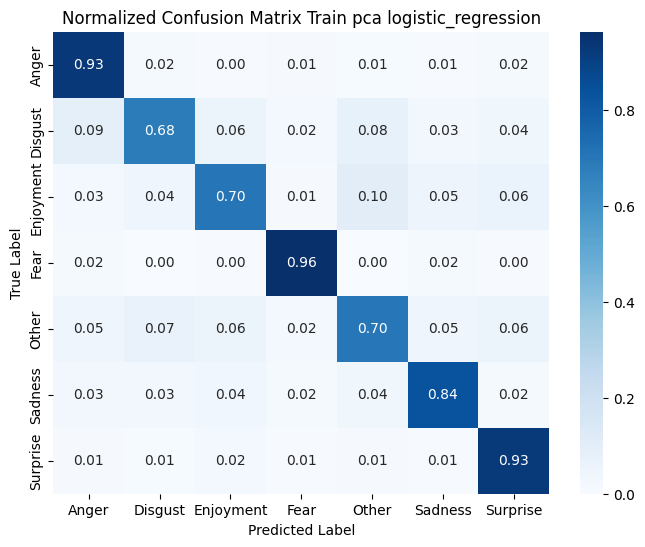

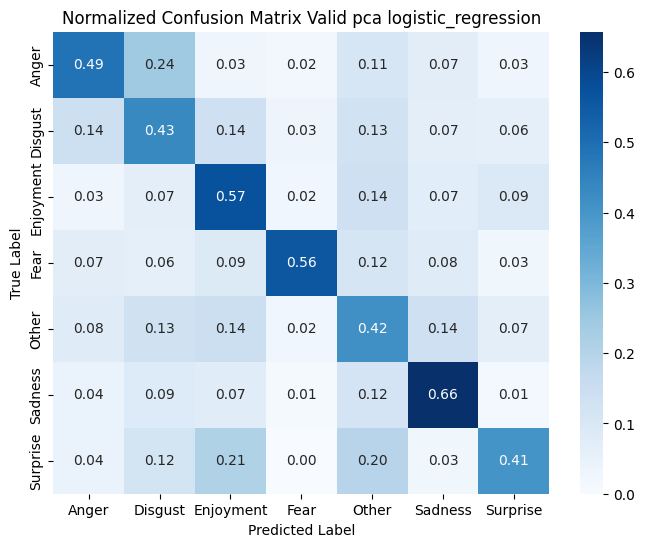

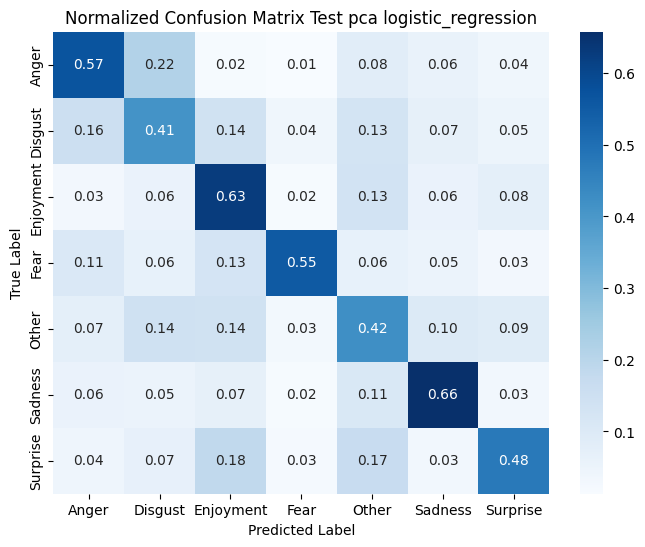

In [83]:
model_pca_3, train_pca_3, valid_pca_3, test_pca_3, pred_pca_3 = pipeline_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=7,
    valid_size=3,
    discriminant="pca", n_components_pca=0.9,
    model_type="logistic_regression",
    max_iter=1000
)

y_train_pca_3, y_valid_pca_3, y_test_pca_3 = train_pca_3[1], valid_pca_3[1], test_pca_3[1]
y_pred_train_pca_3, y_pred_valid_pca_3, y_pred_test_pca_3 = pred_pca_3

pipeline_evaluation(
    y_train_pca_3, y_valid_pca_3, y_test_pca_3,
    y_pred_train_pca_3, y_pred_valid_pca_3, y_pred_test_pca_3,
    train_size=7, valid_size=3,
    discriminant="pca",
    model_type="logistic_regression",
    show_plot=True
)

### Bộ dữ liệu lda

TF-IDF hoàn thành!
Shape: (6036, 7991) (số câu x số từ vựng)
Số từ vựng: 7991
TF-IDF - Non-zero values: 68471


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


--- train --- 7:3 --- logistic_regression --- lda ---
Accuracy: 0.9963552021206097
Recall: 0.9963552021206097
Precision: 0.9964664543114304
F1-score: 0.9963820751085894

--- valid --- 7:3 --- logistic_regression --- lda ---
Accuracy: 0.2751159196290572
Recall: 0.2751159196290572
Precision: 0.33723717096527916
F1-score: 0.2919561928415967

--- test --- 7:3 --- logistic_regression --- lda ---
Accuracy: 0.2727272727272727
Recall: 0.2727272727272727
Precision: 0.33940238371651893
F1-score: 0.2896792407673185


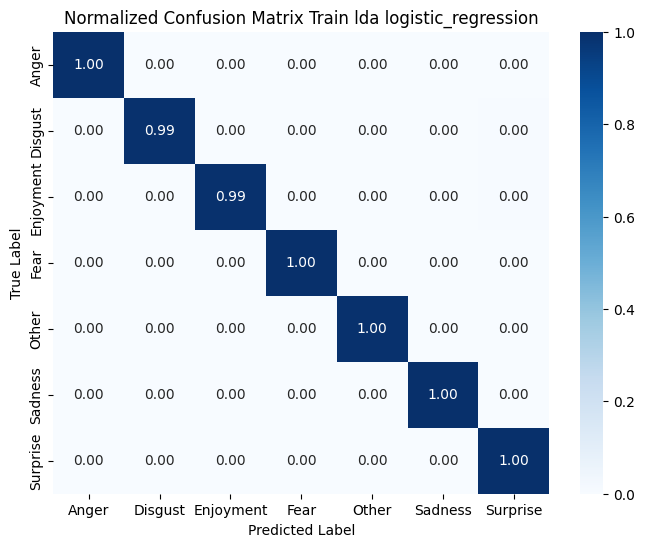

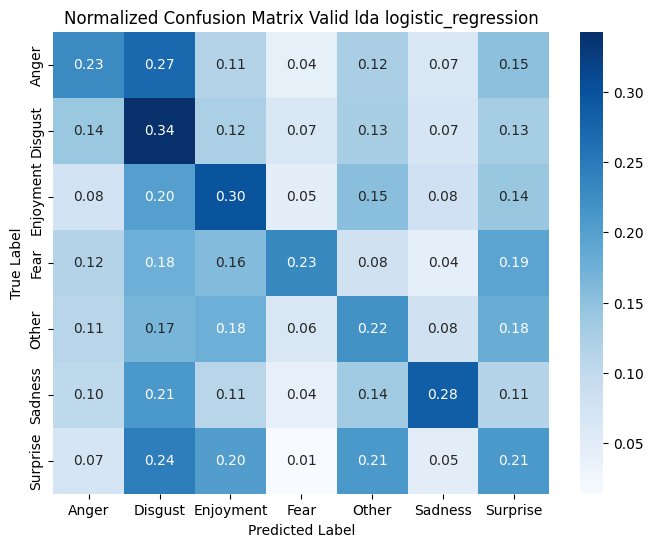

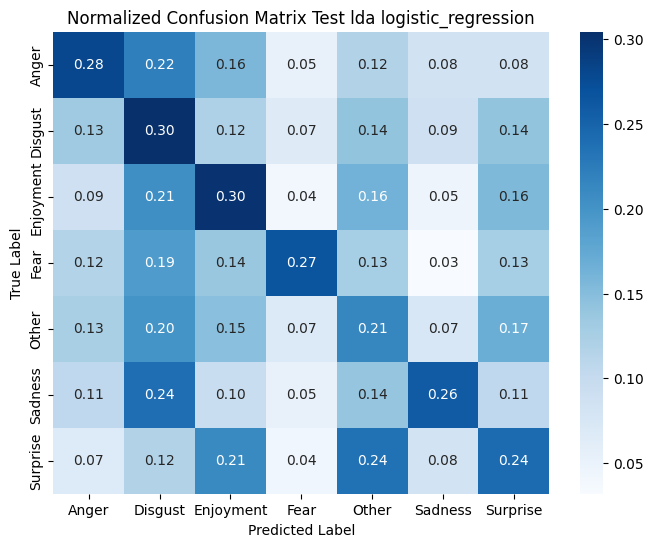

In [84]:
model_lda_3, train_lda_3, valid_lda_3, test_lda_3, pred_lda_3 = pipeline_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=7,
    valid_size=3,
    discriminant="lda", n_components_lda=6,
    model_type="logistic_regression",
    max_iter=1000
)

y_train_lda_3, y_valid_lda_3, y_test_lda_3 = train_lda_3[1], valid_lda_3[1], test_lda_3[1]
y_pred_train_lda_3, y_pred_valid_lda_3, y_pred_test_lda_3 = pred_lda_3

pipeline_evaluation(
    y_train_lda_3, y_valid_lda_3, y_test_lda_3,
    y_pred_train_lda_3, y_pred_valid_lda_3, y_pred_test_lda_3,
    train_size=7, valid_size=3,
    discriminant="lda",
    model_type="logistic_regression",
    show_plot=True
)

## K-NN

### Bộ dữ liệu không giảm chiều

TF-IDF hoàn thành!
Shape: (6036, 7991) (số câu x số từ vựng)
Số từ vựng: 7991
TF-IDF - Non-zero values: 68471
--- train --- 7:3 --- knn --- none ---
Accuracy: 0.47597746852220013
Recall: 0.47597746852220013
Precision: 0.5309690915399619
F1-score: 0.42070636493531527

--- valid --- 7:3 --- knn --- none ---
Accuracy: 0.45865533230293665
Recall: 0.45865533230293665
Precision: 0.4992029526113417
F1-score: 0.39938797898124556

--- test --- 7:3 --- knn --- none ---
Accuracy: 0.45964749536178107
Recall: 0.45964749536178107
Precision: 0.5100985695785648
F1-score: 0.40141588597399797


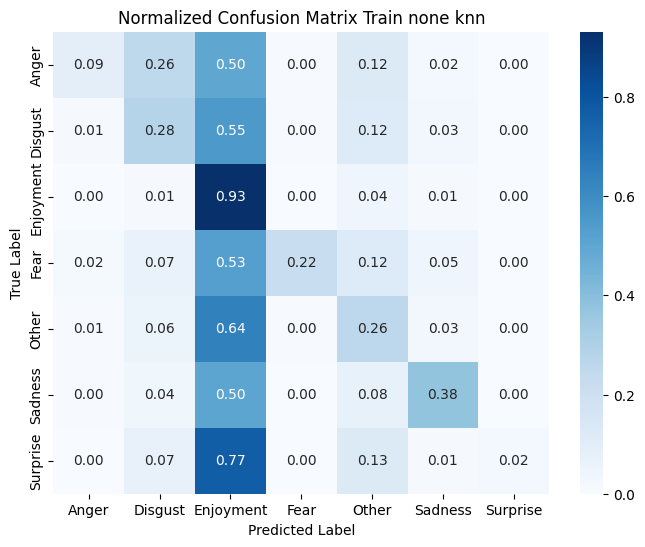

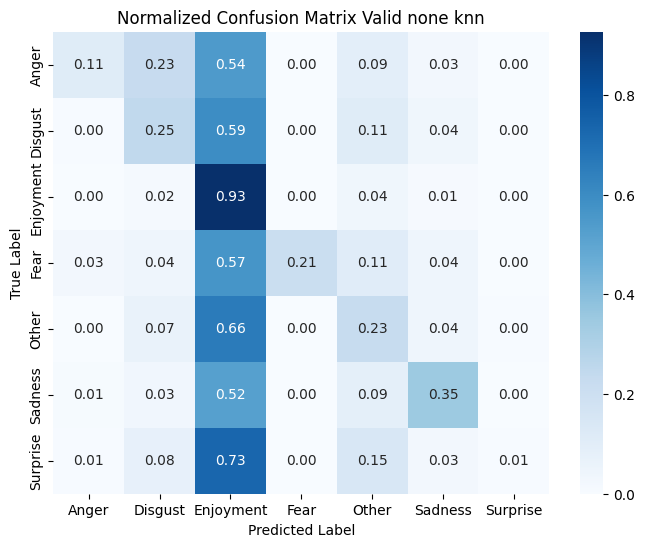

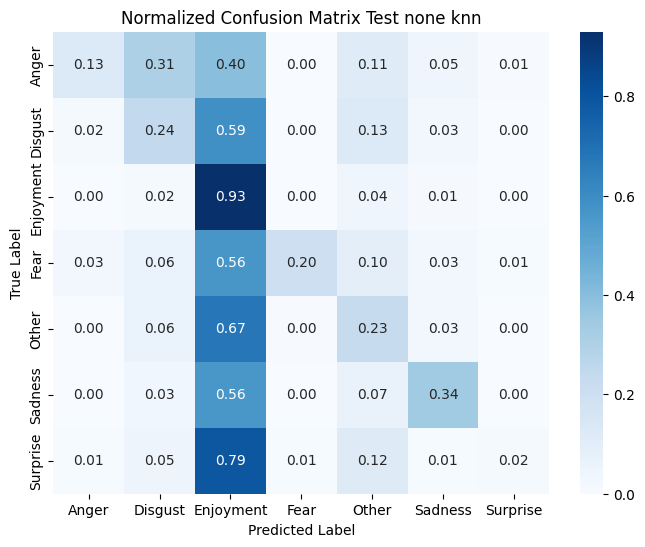

In [85]:
model_4, train_4, valid_4, test_4, pred_4 = pipeline_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=7,
    valid_size=3,
    discriminant="none",
    model_type="knn"
)

y_train_4, y_valid_4, y_test_4 = train_4[1], valid_4[1], test_4[1]
y_pred_train_4, y_pred_valid_4, y_pred_test_4 = pred_4

pipeline_evaluation(
    y_train_4, y_valid_4, y_test_4,
    y_pred_train_4, y_pred_valid_4, y_pred_test_4,
    train_size=7, valid_size=3,
    discriminant="none",
    model_type="knn",
    show_plot=True
)

### Bộ dữ liệu PCA

TF-IDF hoàn thành!
Shape: (6036, 7991) (số câu x số từ vựng)
Số từ vựng: 7991
TF-IDF - Non-zero values: 68471
--- train --- 7:3 --- knn --- pca ---
Accuracy: 0.47813121272365805
Recall: 0.47813121272365805
Precision: 0.532714305567351
F1-score: 0.42344954583723915

--- valid --- 7:3 --- knn --- pca ---
Accuracy: 0.46290571870170016
Recall: 0.46290571870170016
Precision: 0.49185839272737303
F1-score: 0.40404360187751137

--- test --- 7:3 --- knn --- pca ---
Accuracy: 0.4684601113172542
Recall: 0.4684601113172542
Precision: 0.5210429399837355
F1-score: 0.4113180941760334


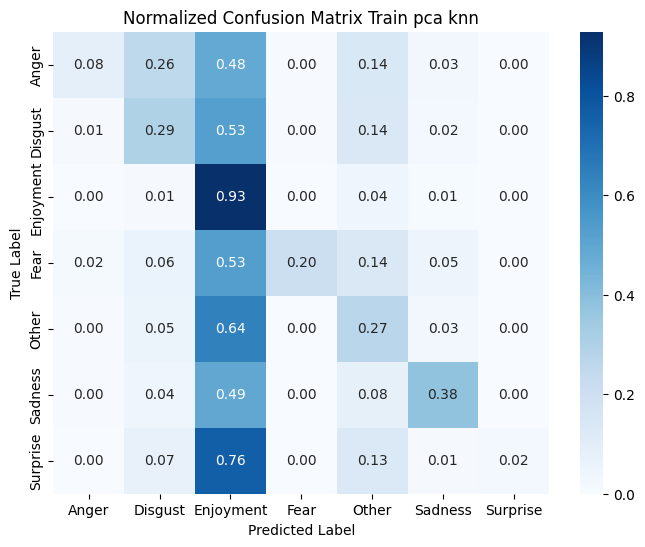

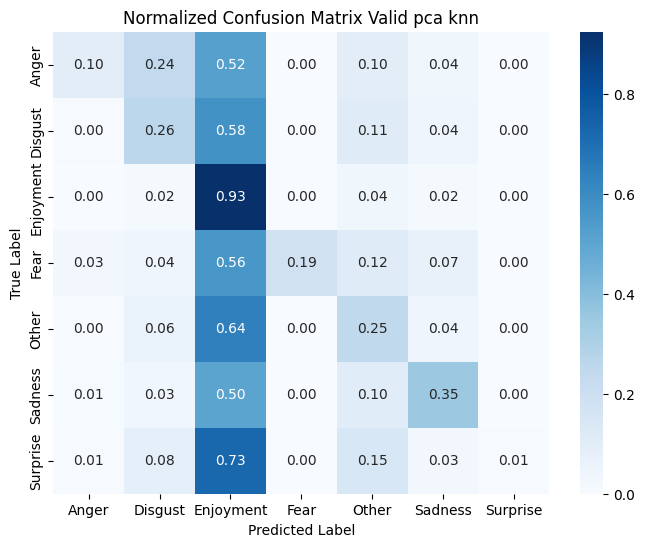

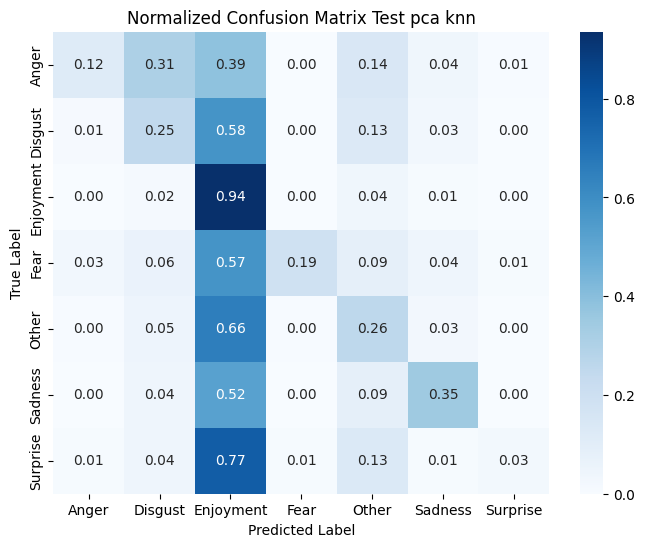

In [86]:
model_pca_4, train_pca_4, valid_pca_4, test_pca_4, pred_pca_4 = pipeline_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=7,
    valid_size=3,
    discriminant="pca", n_components_pca=0.9,
    model_type="knn",
    max_iter=1000
)

y_train_pca_4, y_valid_pca_4, y_test_pca_4 = train_pca_4[1], valid_pca_4[1], test_pca_4[1]
y_pred_train_pca_4, y_pred_valid_pca_4, y_pred_test_pca_4 = pred_pca_4

pipeline_evaluation(
    y_train_pca_4, y_valid_pca_4, y_test_pca_4,
    y_pred_train_pca_4, y_pred_valid_pca_4, y_pred_test_pca_4,
    train_size=7, valid_size=3,
    discriminant="pca",
    model_type="knn",
    show_plot=True
)

### Bộ dữ liệu lda

TF-IDF hoàn thành!
Shape: (6036, 7991) (số câu x số từ vựng)
Số từ vựng: 7991
TF-IDF - Non-zero values: 68471
--- train --- 7:3 --- knn --- lda ---
Accuracy: 0.9950298210735586
Recall: 0.9950298210735586
Precision: 0.9950937018383395
F1-score: 0.9950446621860236

--- valid --- 7:3 --- knn --- lda ---
Accuracy: 0.27202472952086554
Recall: 0.27202472952086554
Precision: 0.3495349012537632
F1-score: 0.289812500915685

--- test --- 7:3 --- knn --- lda ---
Accuracy: 0.2680890538033395
Recall: 0.2680890538033395
Precision: 0.3361057340851463
F1-score: 0.2838479618915148


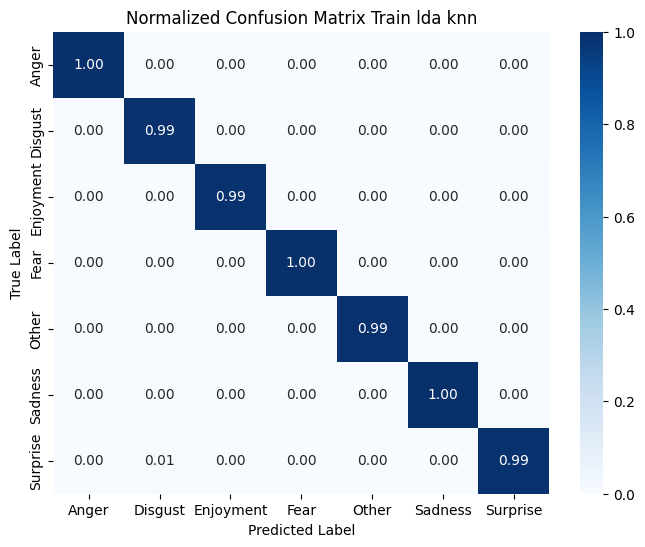

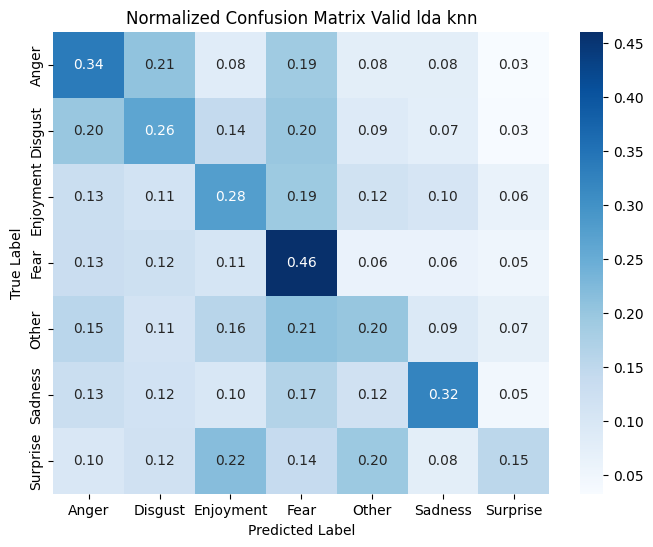

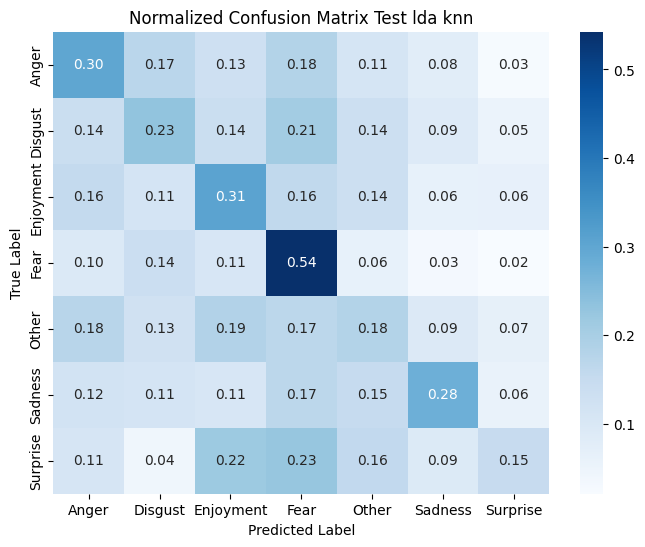

In [87]:
model_lda_4, train_lda_4, valid_lda_4, test_lda_4, pred_lda_4 = pipeline_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=7,
    valid_size=3,
    discriminant="lda", n_components_lda=6,
    model_type="knn",
    max_iter=1000
)

y_train_lda_4, y_valid_lda_4, y_test_lda_4 = train_lda_4[1], valid_lda_4[1], test_lda_4[1]
y_pred_train_lda_4, y_pred_valid_lda_4, y_pred_test_lda_4 = pred_lda_4

pipeline_evaluation(
    y_train_lda_4, y_valid_lda_4, y_test_lda_4,
    y_pred_train_lda_4, y_pred_valid_lda_4, y_pred_test_lda_4,
    train_size=7, valid_size=3,
    discriminant="lda",
    model_type="knn",
    show_plot=True
)

# Test:Validation = 6:4

## Logistic Regression

### Bộ dữ liệu không giảm chiều

TF-IDF hoàn thành!
Shape: (5174, 6990) (số câu x số từ vựng)
Số từ vựng: 6990
TF-IDF - Non-zero values: 57838


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


--- train --- 6:4 --- logistic_regression --- none ---
Accuracy: 0.812137611132586
Recall: 0.812137611132586
Precision: 0.8261178390934237
F1-score: 0.8125013521191538

--- valid --- 6:4 --- logistic_regression --- none ---
Accuracy: 0.5185507246376811
Recall: 0.5185507246376811
Precision: 0.538337749140281
F1-score: 0.5253184176433153

--- test --- 6:4 --- logistic_regression --- none ---
Accuracy: 0.5333951762523191
Recall: 0.5333951762523191
Precision: 0.5521091735880028
F1-score: 0.5391028209811535


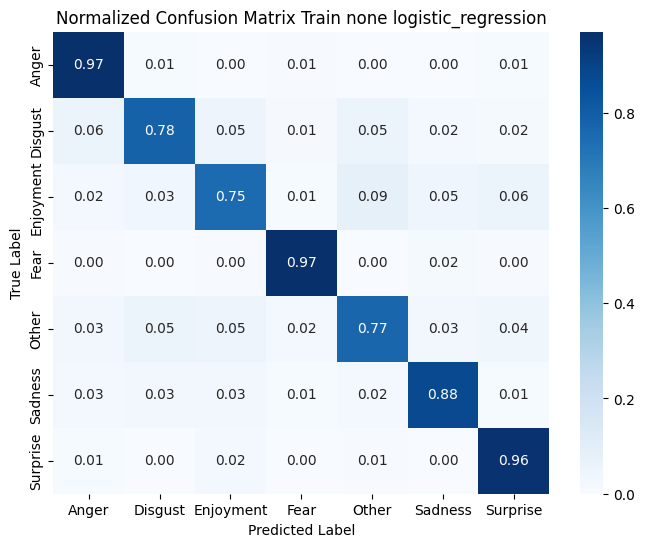

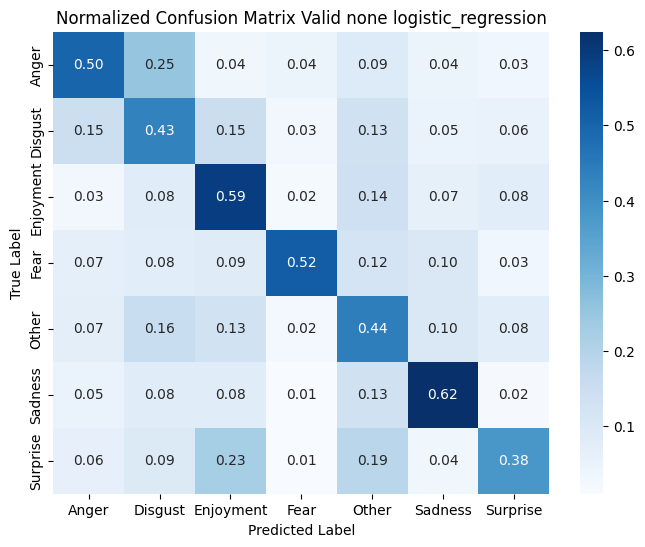

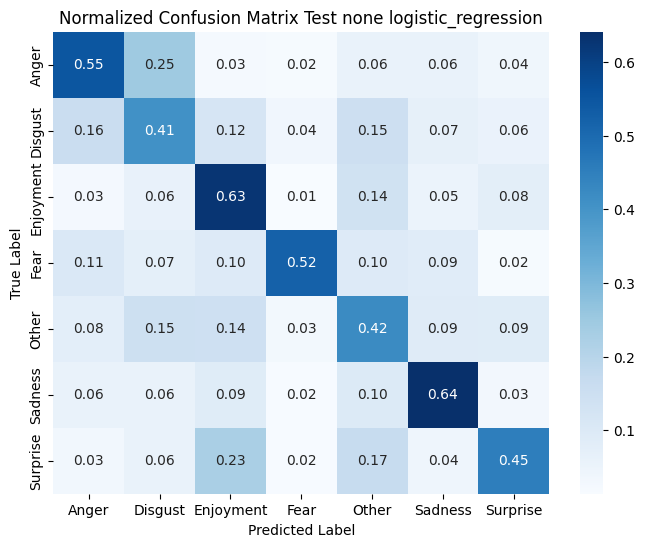

In [88]:
model_5, train_5, valid_5, test_5, pred_5 = pipeline_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=6,
    valid_size=4,
    discriminant="none",
    model_type="logistic_regression",
    max_iter=1000
)

y_train_5, y_valid_5, y_test_5 = train_5[1], valid_5[1], test_5[1]
y_pred_train_5, y_pred_valid_5, y_pred_test_5 = pred_5
pipeline_evaluation(
    y_train_5, y_valid_5, y_test_5,
    y_pred_train_5, y_pred_valid_5, y_pred_test_5,
    train_size=6, valid_size=4,
    discriminant="none",
    model_type="logistic_regression",
    show_plot=True
)

### Bộ dữ liệu PCA

TF-IDF hoàn thành!
Shape: (5174, 6990) (số câu x số từ vựng)
Số từ vựng: 6990
TF-IDF - Non-zero values: 57838


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


--- train --- 6:4 --- logistic_regression --- pca ---
Accuracy: 0.7651720139157325
Recall: 0.7651720139157325
Precision: 0.785587786906512
F1-score: 0.7662211252903434

--- valid --- 6:4 --- logistic_regression --- pca ---
Accuracy: 0.5040579710144928
Recall: 0.5040579710144928
Precision: 0.5272982602598634
F1-score: 0.5115856176127666

--- test --- 6:4 --- logistic_regression --- pca ---
Accuracy: 0.524582560296846
Recall: 0.524582560296846
Precision: 0.5443523708924135
F1-score: 0.530174303689146


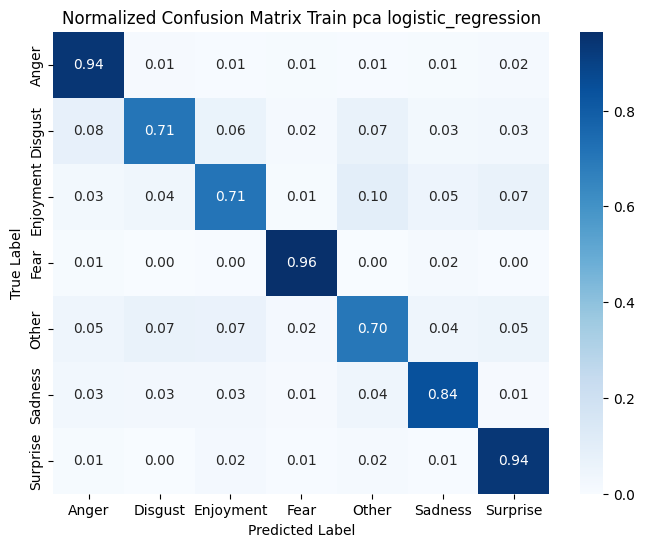

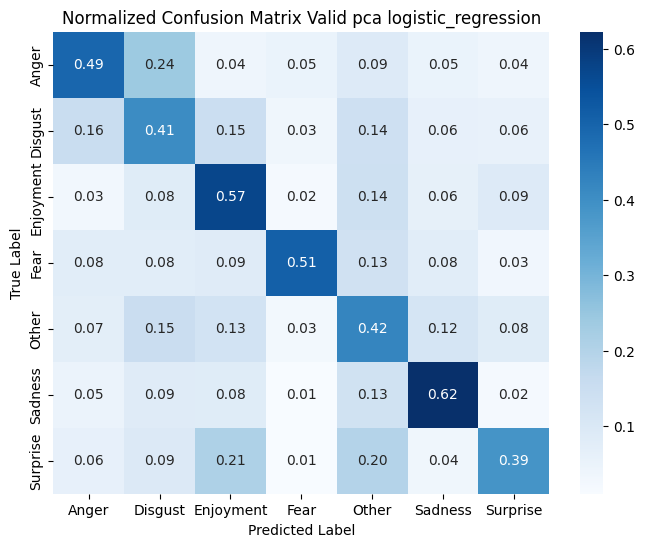

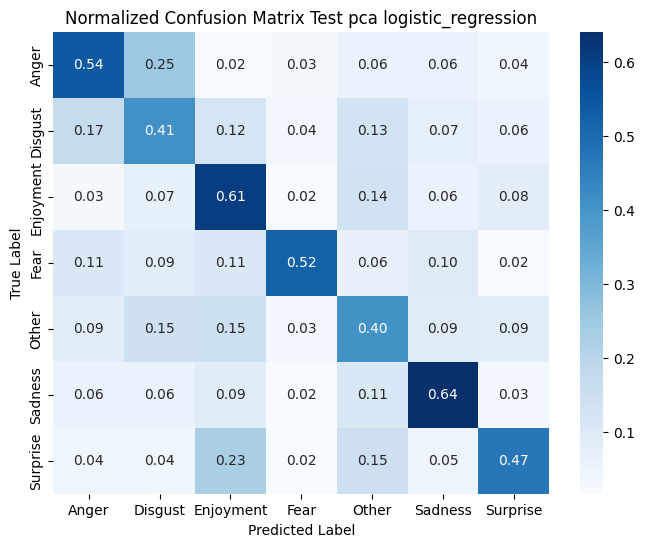

In [89]:
model_pca_5, train_pca_5, valid_pca_5, test_pca_5, pred_pca_5 = pipeline_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=6,
    valid_size=4,
    discriminant="pca", n_components_pca=0.9,
    model_type="logistic_regression",
    max_iter=1000
)

y_train_pca_5, y_valid_pca_5, y_test_pca_5 = train_pca_5[1], valid_pca_5[1], test_pca_5[1]
y_pred_train_pca_5, y_pred_valid_pca_5, y_pred_test_pca_5 = pred_pca_5

pipeline_evaluation(
    y_train_pca_5, y_valid_pca_5, y_test_pca_5,
    y_pred_train_pca_5, y_pred_valid_pca_5, y_pred_test_pca_5,
    train_size=6, valid_size=4,
    discriminant="pca",
    model_type="logistic_regression",
    show_plot=True
)

### Bộ dữ liệu lda

TF-IDF hoàn thành!
Shape: (5174, 6990) (số câu x số từ vựng)
Số từ vựng: 6990
TF-IDF - Non-zero values: 57838


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


--- train --- 6:4 --- logistic_regression --- lda ---
Accuracy: 0.9976807112485504
Recall: 0.9976807112485504
Precision: 0.9977454426637807
F1-score: 0.9976954425458414

--- valid --- 6:4 --- logistic_regression --- lda ---
Accuracy: 0.25507246376811593
Recall: 0.25507246376811593
Precision: 0.30988526450153664
F1-score: 0.2673133364714646

--- test --- 6:4 --- logistic_regression --- lda ---
Accuracy: 0.2597402597402597
Recall: 0.2597402597402597
Precision: 0.31695114151961185
F1-score: 0.2743576703954364


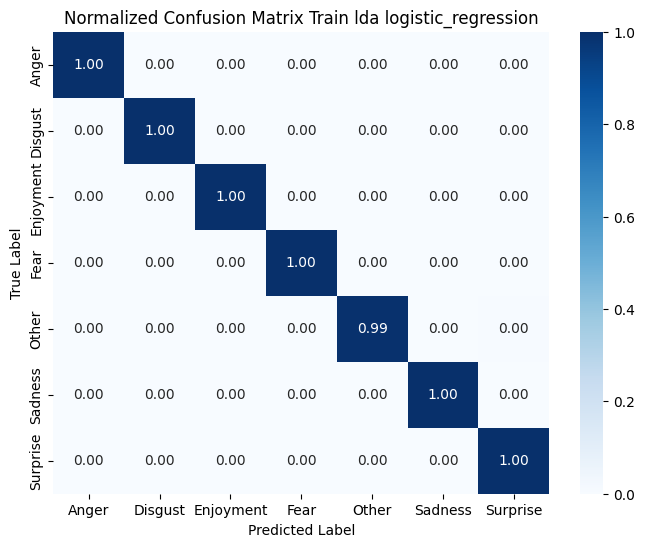

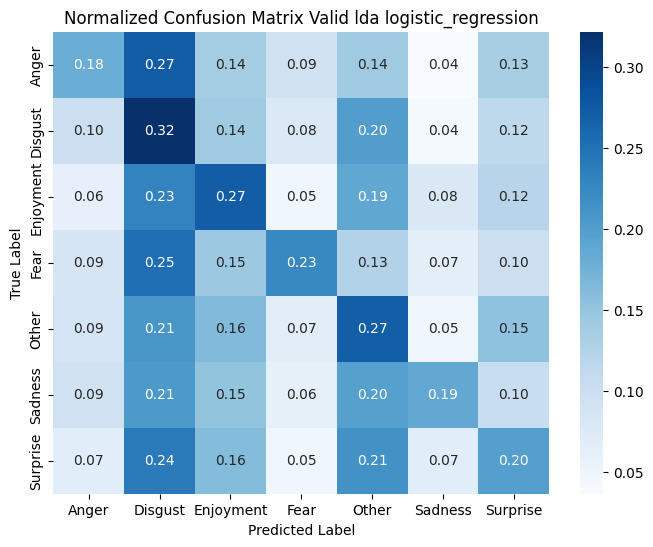

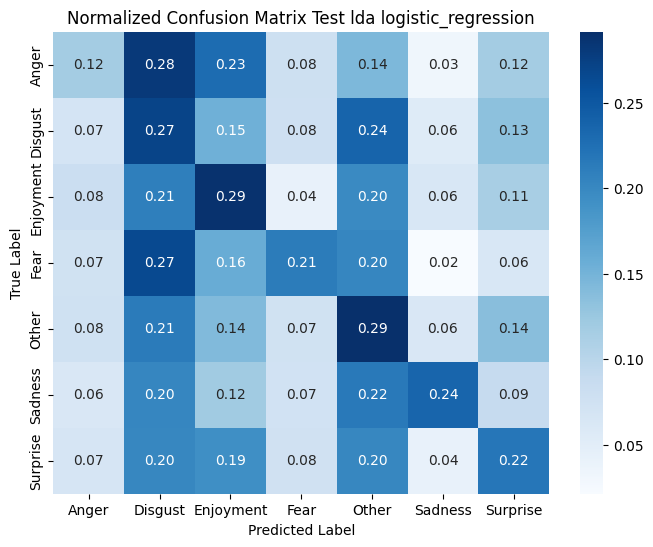

In [90]:
model_lda_5, train_lda_5, valid_lda_5, test_lda_5, pred_lda_5 = pipeline_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=6,
    valid_size=4,
    discriminant="lda", n_components_lda=6,
    model_type="logistic_regression",
    max_iter=1000
)

y_train_lda_5, y_valid_lda_5, y_test_lda_5 = train_lda_5[1], valid_lda_5[1], test_lda_5[1]
y_pred_train_lda_5, y_pred_valid_lda_5, y_pred_test_lda_5 = pred_lda_5

pipeline_evaluation(
    y_train_lda_5, y_valid_lda_5, y_test_lda_5,
    y_pred_train_lda_5, y_pred_valid_lda_5, y_pred_test_lda_5,
    train_size=6, valid_size=4,
    discriminant="lda",
    model_type="logistic_regression",
    show_plot=True
)

## K-NN

### Bộ dữ liệu không giảm chiều

TF-IDF hoàn thành!
Shape: (5174, 6990) (số câu x số từ vựng)
Số từ vựng: 6990
TF-IDF - Non-zero values: 57838
--- train --- 6:4 --- knn --- none ---
Accuracy: 0.47197526091998454
Recall: 0.47197526091998454
Precision: 0.5327201196133295
F1-score: 0.41618881804599867

--- valid --- 6:4 --- knn --- none ---
Accuracy: 0.45159420289855073
Recall: 0.45159420289855073
Precision: 0.4965912752207736
F1-score: 0.38976718732223387

--- test --- 6:4 --- knn --- none ---
Accuracy: 0.45918367346938777
Recall: 0.45918367346938777
Precision: 0.5214531397827566
F1-score: 0.40048533736331726


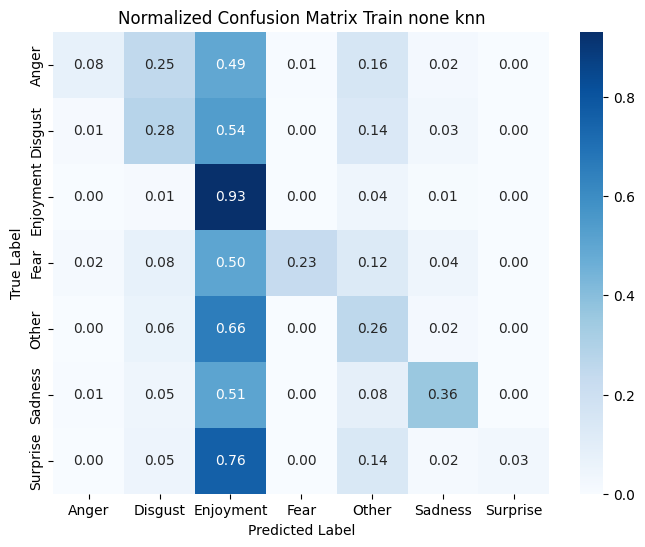

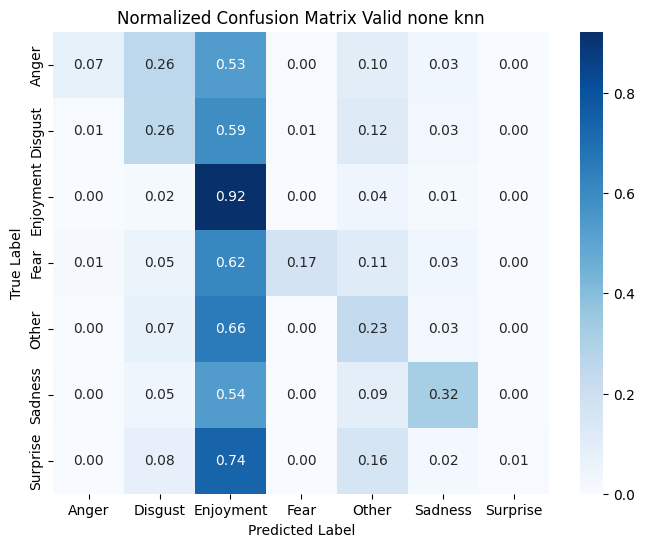

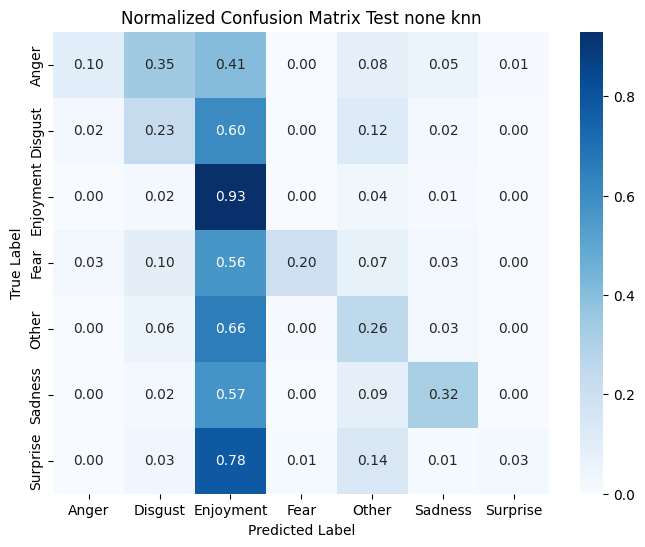

In [91]:
model_6, train_6, valid_6, test_6, pred_6 = pipeline_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=6,
    valid_size=4,
    discriminant="none",
    model_type="knn"
)

y_train_6, y_valid_6, y_test_6 = train_6[1], valid_6[1], test_6[1]
y_pred_train_6, y_pred_valid_6, y_pred_test_6 = pred_6

pipeline_evaluation(
    y_train_6, y_valid_6, y_test_6,
    y_pred_train_6, y_pred_valid_6, y_pred_test_6,
    train_size=6, valid_size=4,
    discriminant="none",
    model_type="knn",
    show_plot=True
)

### Bộ dữ liệu PCA

TF-IDF hoàn thành!
Shape: (5174, 6990) (số câu x số từ vựng)
Số từ vựng: 6990
TF-IDF - Non-zero values: 57838
--- train --- 6:4 --- knn --- pca ---
Accuracy: 0.47081561654425974
Recall: 0.47081561654425974
Precision: 0.5282661178037222
F1-score: 0.41475891097180695

--- valid --- 6:4 --- knn --- pca ---
Accuracy: 0.4544927536231884
Recall: 0.4544927536231884
Precision: 0.47492262958392967
F1-score: 0.3955293692310963

--- test --- 6:4 --- knn --- pca ---
Accuracy: 0.45964749536178107
Recall: 0.45964749536178107
Precision: 0.5165815189469448
F1-score: 0.40171649217185623


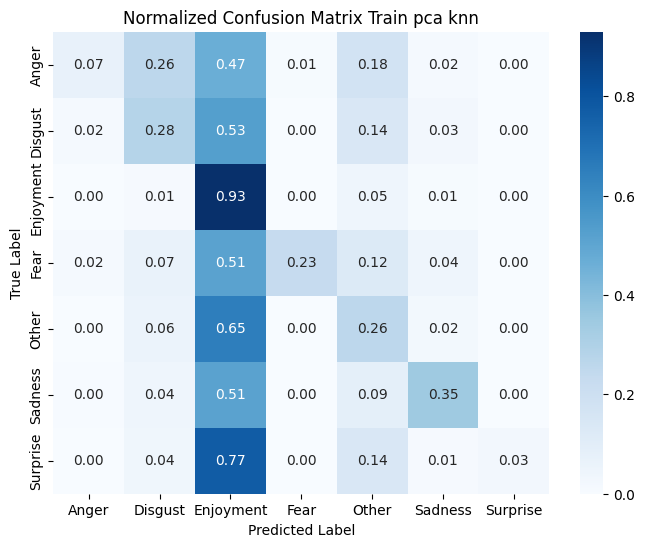

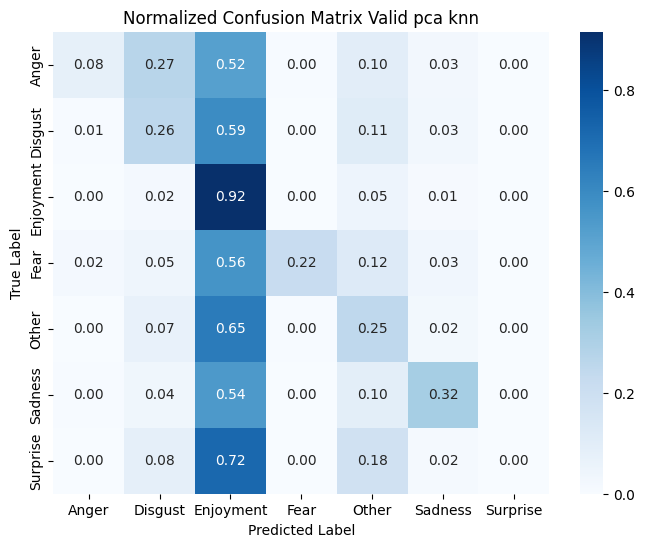

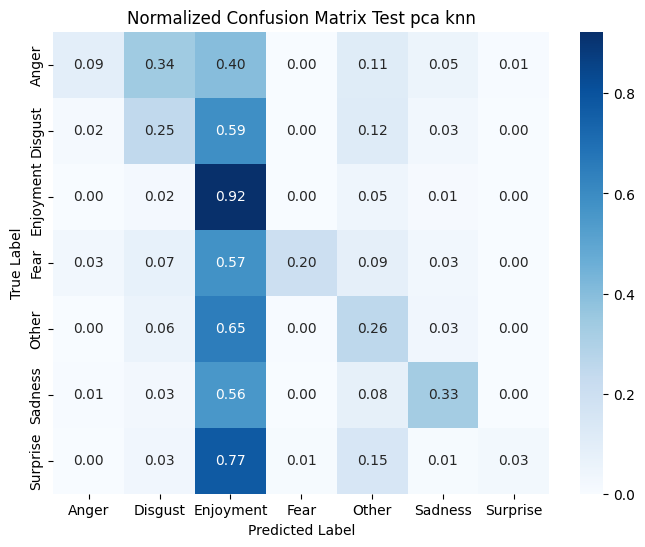

In [92]:
model_pca_6, train_pca_6, valid_pca_6, test_pca_6, pred_pca_6 = pipeline_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=6,
    valid_size=4,
    discriminant="pca", n_components_pca=0.9,
    model_type="knn",
    max_iter=1000
)

y_train_pca_6, y_valid_pca_6, y_test_pca_6 = train_pca_6[1], valid_pca_6[1], test_pca_6[1]
y_pred_train_pca_6, y_pred_valid_pca_6, y_pred_test_pca_6 = pred_pca_6

pipeline_evaluation(
    y_train_pca_6, y_valid_pca_6, y_test_pca_6,
    y_pred_train_pca_6, y_pred_valid_pca_6, y_pred_test_pca_6,
    train_size=6, valid_size=4,
    discriminant="pca",
    model_type="knn",
    show_plot=True
)

### Bộ dữ liệu lda

TF-IDF hoàn thành!
Shape: (5174, 6990) (số câu x số từ vựng)
Số từ vựng: 6990
TF-IDF - Non-zero values: 57838
--- train --- 6:4 --- knn --- lda ---
Accuracy: 0.9957479706223424
Recall: 0.9957479706223424
Precision: 0.995773645160491
F1-score: 0.9957498543140142

--- valid --- 6:4 --- knn --- lda ---
Accuracy: 0.25855072463768114
Recall: 0.25855072463768114
Precision: 0.3368053779865382
F1-score: 0.2742419142864651

--- test --- 6:4 --- knn --- lda ---
Accuracy: 0.2560296846011132
Recall: 0.2560296846011132
Precision: 0.3247795904433649
F1-score: 0.27147629601870166


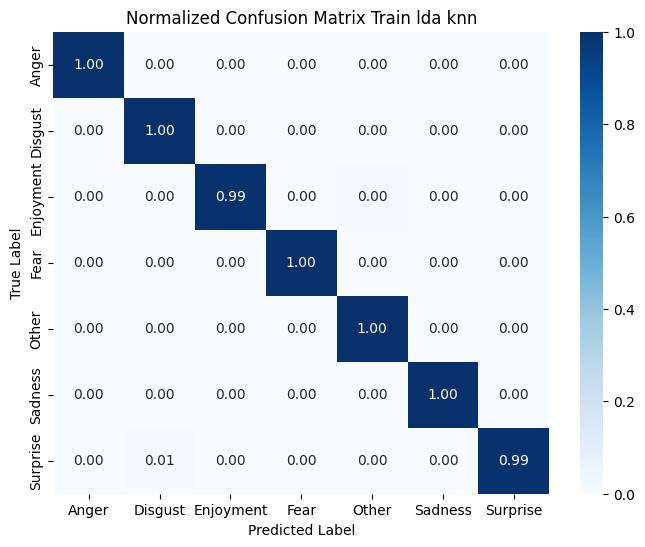

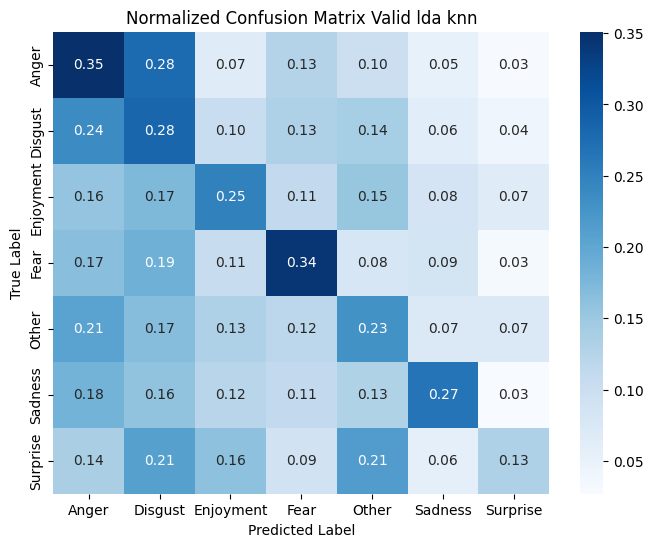

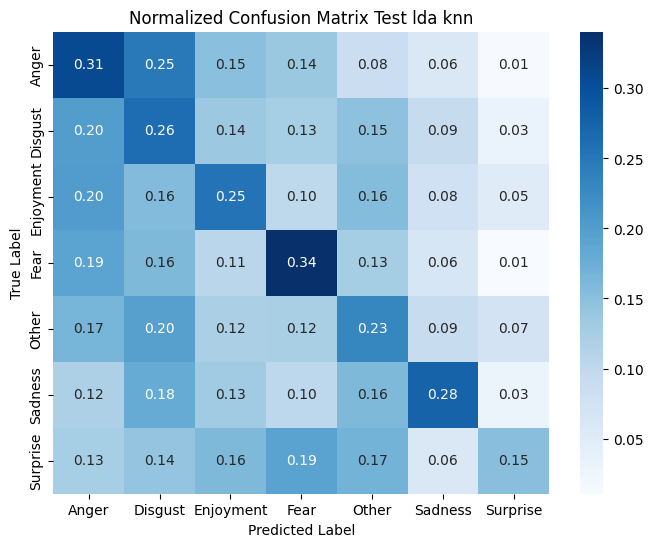

In [93]:
model_lda_6, train_lda_6, valid_lda_6, test_lda_6, pred_lda_6 = pipeline_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=6,
    valid_size=4,
    discriminant="lda", n_components_lda=6,
    model_type="knn",
    max_iter=1000
)

y_train_lda_6, y_valid_lda_6, y_test_lda_6 = train_lda_6[1], valid_lda_6[1], test_lda_6[1]
y_pred_train_lda_6, y_pred_valid_lda_6, y_pred_test_lda_6 = pred_lda_6

pipeline_evaluation(
    y_train_lda_6, y_valid_lda_6, y_test_lda_6,
    y_pred_train_lda_6, y_pred_valid_lda_6, y_pred_test_lda_6,
    train_size=6, valid_size=4,
    discriminant="lda",
    model_type="knn",
    show_plot=True
)